In [54]:
from numpy import *
from PlotFuncs import *
from LabFuncs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import jit,njit,prange
from numpy import random
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import norm
import cmocean
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.colors as colors

from scipy.special import erf
from scipy.optimize import fsolve

def DiscoveryLimit(costh_samples,sig=3,nbins=1000):
    h,ce = histogram(costh_samples,nbins)
    cc = (ce[1:]+ce[0:-1])/2
    
    P_costh = h/sum(h) 
    
    fs = lambda P0 : 0.5-sum(0.5*(1+erf((sig-P0*cc)/sqrt(2)))*P_costh)
    res = fsolve(fs,sig)
    cval_disc = (sig)/res
    return cval_disc


@njit(parallel=True)
def Polarisation_costhsq_Galactic(X_gal,Axis,t_vals,lat=45.0,lon=0.0,Planar=False,JD_0=Jan1):
    nt = len(t_vals)
    ngen = shape(X_gal)[0]
    costh_sq = zeros(shape=(ngen,nt))
    Axis_V = zeros(shape=(ngen,3))
    for i in prange(0,ngen):
        Axis_V[i,:] = 1*Axis
        
    for i in prange(0,nt):
        costh_sq[:,i] = sum(X_gal*lab2gal(Axis_V,t_vals[i]+JD_0,lat,lon),1)**2
    
    if Planar:
        costh_sq = 1-costh_sq
    return costh_sq

def X_from_lb(l,b):
    X_test = zeros(shape=(1,3))
    X_test[0,:] = array([cos(l*pi/180)*cos(b*pi/180),\
                         sin(l*pi/180)*cos(b*pi/180),\
                         sin(b*pi/180)])
    return X_test

def X_galactic(n):
    nn = int(n*n/2)
    l, b = meshgrid(linspace(-pi, pi, n), linspace(-pi/2, pi/2, int(n/2)))
    X = cos(l)*cos(b)
    Y = sin(l)*cos(b)
    Z = sin(b)
    ii = 0
    X_gal = zeros(shape=(nn,3))
    for i in range(0,int(n/2)):
        for j in range(0,n):
            X_gal[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
            ii = ii+1
    return l,b,X_gal

def TestStatistic(t_vals,costh2_obs,costh2_exp,costh2_95_short,t_short,TS_short):
    ngen = shape(costh2_exp)[0]
    nt = shape(costh2_exp)[1]
    TS = zeros(shape=ngen)
    C_obs = trapz(costh2_obs,t_vals)/t_vals[-1]

    for i in range(0,ngen):
        C_exp = trapz(costh2_exp[i,:],t_vals)/t_vals[-1]
        L1 = (1/t_short)*trapz((costh2_obs-costh2_exp[i,:])**2,t_vals)
        L0 = (t_vals[-1]*C_obs*(1/t_short - 1/t_vals[-1]))**2
        TS[i] = (TS_short**2/costh2_95_short**2)*(L0-L1)
    return TS

#@jit(parallel=True)
def TestStatistic_Map(n,X_test,Axis,T,lat,lon=0,t_short=1,dt=0.1,TS_thresh=-6.1,TS_short=3,Planar=False,JD_0=Jan1):
    t_vals = arange(0,T+dt,dt)
    nt = len(t_vals)
    l,b,X_gal = X_galactic(n)
    nn = int(n*n/2)
    
    costh2_test = Polarisation_costhsq_Galactic(X_test,Axis,t_vals,lat,lon,Planar=Planar,JD_0=JD_0)

    costh2_short = Polarisation_costhsq_Galactic(X_gal,Axis,linspace(0,t_short,100),lat,lon,Planar=Planar,JD_0=JD_0)
    costh2_av_short = zeros(shape=nn)
    for i in range(0,nn):
        costh2_av_short[i] = trapz(costh2_short[i,:],linspace(0,t_short,100))/t_short
    #costh2_95_short = sort(costh2_av_short)[int(0.05*nn)]
    costh2_95_short = DiscoveryLimit(costh2_av_short)
    
    costh2 = Polarisation_costhsq_Galactic(X_gal,Axis,t_vals,lat,lon,Planar=Planar,JD_0=JD_0)


    L = TestStatistic(t_vals,costh2_test,costh2,costh2_95_short,t_short,TS_short)  

    L_map = zeros(shape=(int(n/2),n))
    ii = 0
    for i in range(0,int(n/2)):
        for j in range(0,n):
            L_map[i,j] = L[ii]
            ii += 1
    
    L_map = L_map-amax(L_map)
    
    th_int = linspace(-pi/2, pi/2, int(n/2))
    phi_int = linspace(-pi,pi,n)

    L_mask = ones(shape=shape(L_map))
    L_mask[L_map<TS_thresh] = 0

    dO = trapz(trapz(L_mask,phi_int)*cos(th_int),th_int)/(4*pi)

    return l,b,L_map,dO



In [71]:
n = 200

l_test1 = 90
b_test1 = 30
X_test1 = X_from_lb(l_test1,b_test1)

l_test2 = 100
b_test2 = 30
X_test2 = X_from_lb(l_test2,b_test2)

l_test3 = 90
b_test3 = 30
X_test3 = X_from_lb(l_test3,b_test3)

Zenith = array([0,0,1])
West = array([0,1,0])
North = array([1,0,0])

lat1 = 45.0
Axis1 = North
cmap1 = cm.Greens

lat2 = 45.0
Axis2 = West
cmap2 = cm.Blues

lat3 = 45.0
Axis3 = Zenith
cmap3 = cm.Reds

T1 = 0.25
T2 = 0.5
T3 = 1
T4 = 5
T5 = 25

l,b,L_map_N31,dO = TestStatistic_Map(n,X_test1,Axis1,T1,lat1)
l,b,L_map_N32,dO = TestStatistic_Map(n,X_test1,Axis1,T2,lat1)
l,b,L_map_N33,dO = TestStatistic_Map(n,X_test1,Axis1,T3,lat1)
l,b,L_map_N34,dO = TestStatistic_Map(n,X_test1,Axis1,T4,lat1)
l,b,L_map_N35,dO = TestStatistic_Map(n,X_test1,Axis1,T5,lat1)

l,b,L_map_W31,dO = TestStatistic_Map(n,X_test2,Axis2,T1,lat2)
l,b,L_map_W32,dO = TestStatistic_Map(n,X_test2,Axis2,T2,lat2)
l,b,L_map_W33,dO = TestStatistic_Map(n,X_test2,Axis2,T3,lat2)
l,b,L_map_W34,dO = TestStatistic_Map(n,X_test2,Axis2,T4,lat2)
l,b,L_map_W35,dO = TestStatistic_Map(n,X_test2,Axis2,T5,lat2)

l,b,L_map_Z31,dO = TestStatistic_Map(n,X_test3,Axis3,T1,lat3)
l,b,L_map_Z32,dO = TestStatistic_Map(n,X_test3,Axis3,T2,lat3)
l,b,L_map_Z33,dO = TestStatistic_Map(n,X_test3,Axis3,T3,lat3)
l,b,L_map_Z34,dO = TestStatistic_Map(n,X_test3,Axis3,T4,lat3)
l,b,L_map_Z35,dO = TestStatistic_Map(n,X_test3,Axis3,T5,lat3)


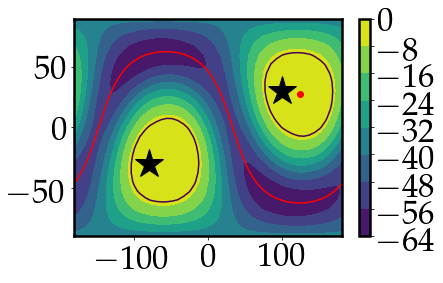

In [52]:
plt.contourf(rad2deg(l), rad2deg(b),L_map_W33)
plt.colorbar()
plt.contour(rad2deg(l), rad2deg(b),L_map_W33,levels=[-6,0])

#plt.colorbar()
#plt.contour(rad2deg(l), rad2deg(b),L_map_W31-amax(L_map_W31),levels=[-6])

plt.plot(l_test2,b_test2,'*',ms=30,mec='k',mfc='k')
plt.plot(l_test2-180,-b_test2,'*',ms=30,mec='k',mfc='k',label='True polarisation axis')

    
def Equator(n):
    q_eqt = zeros(shape=(n,3))
    q_eqt[:,0] = sin(linspace(-pi,pi,n))
    q_eqt[:,1] = cos(linspace(-pi,pi,n))    
    q_eqt = eqt2gal(q_eqt)
    b = arcsin(q_eqt[:,2])*180/pi
    l = arctan2(q_eqt[:,1],q_eqt[:,0])*180/pi
    l[l>180] = l[l>180]-360
    b = b[argsort(l)]
    l = l[argsort(l)]
    return l,b

q_NP = zeros(shape=(1,3))
q_NP[0,:] = array([0,0,1])
q_NP = eqt2gal(q_NP)
b_NP = arcsin(q_NP[0,2])*180/pi
l_NP = arctan2(q_NP[0,1],q_NP[0,0])*180/pi
plt.plot(l_NP,b_NP,'ro')

l_eqt,b_eqt = Equator(500)
plt.plot(l_eqt,b_eqt,'r-')



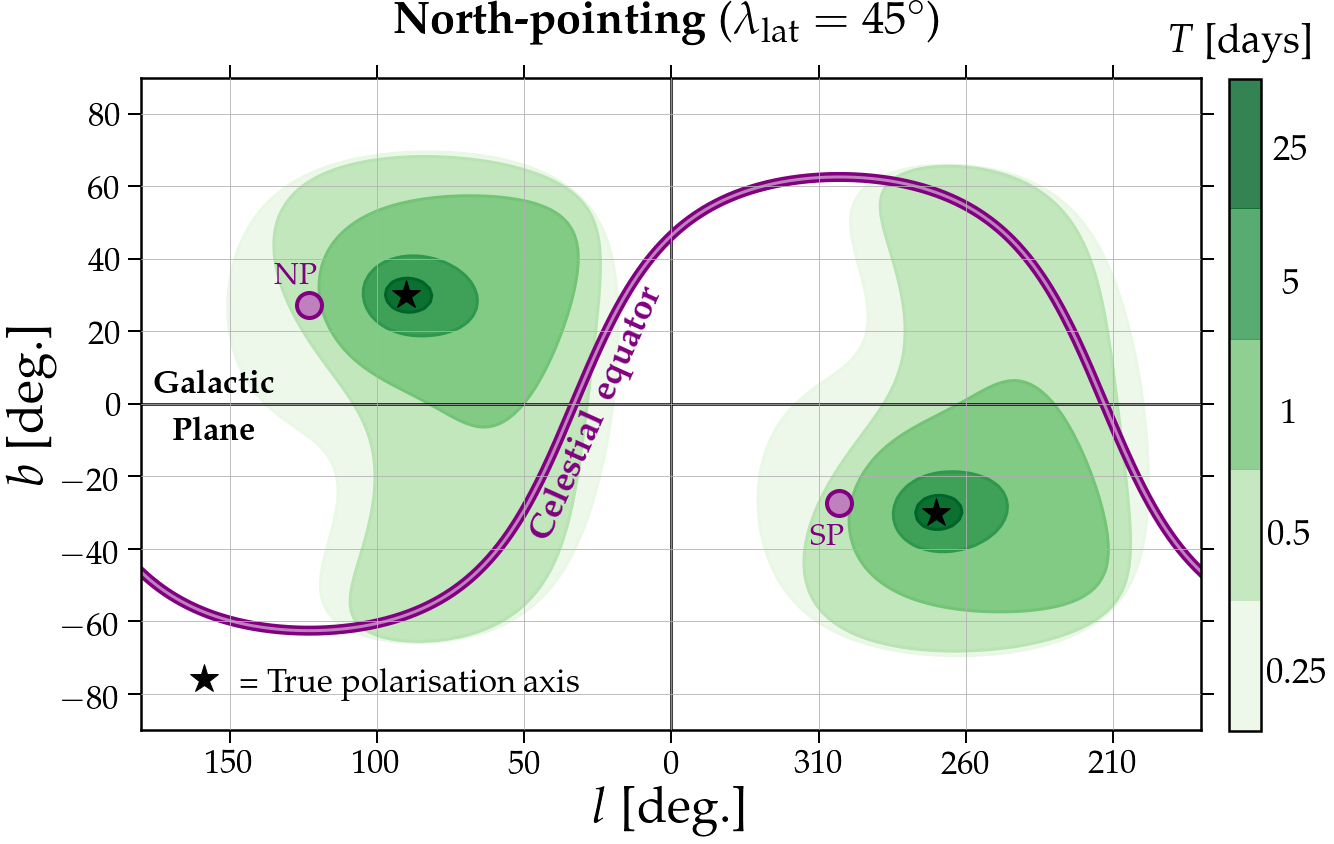

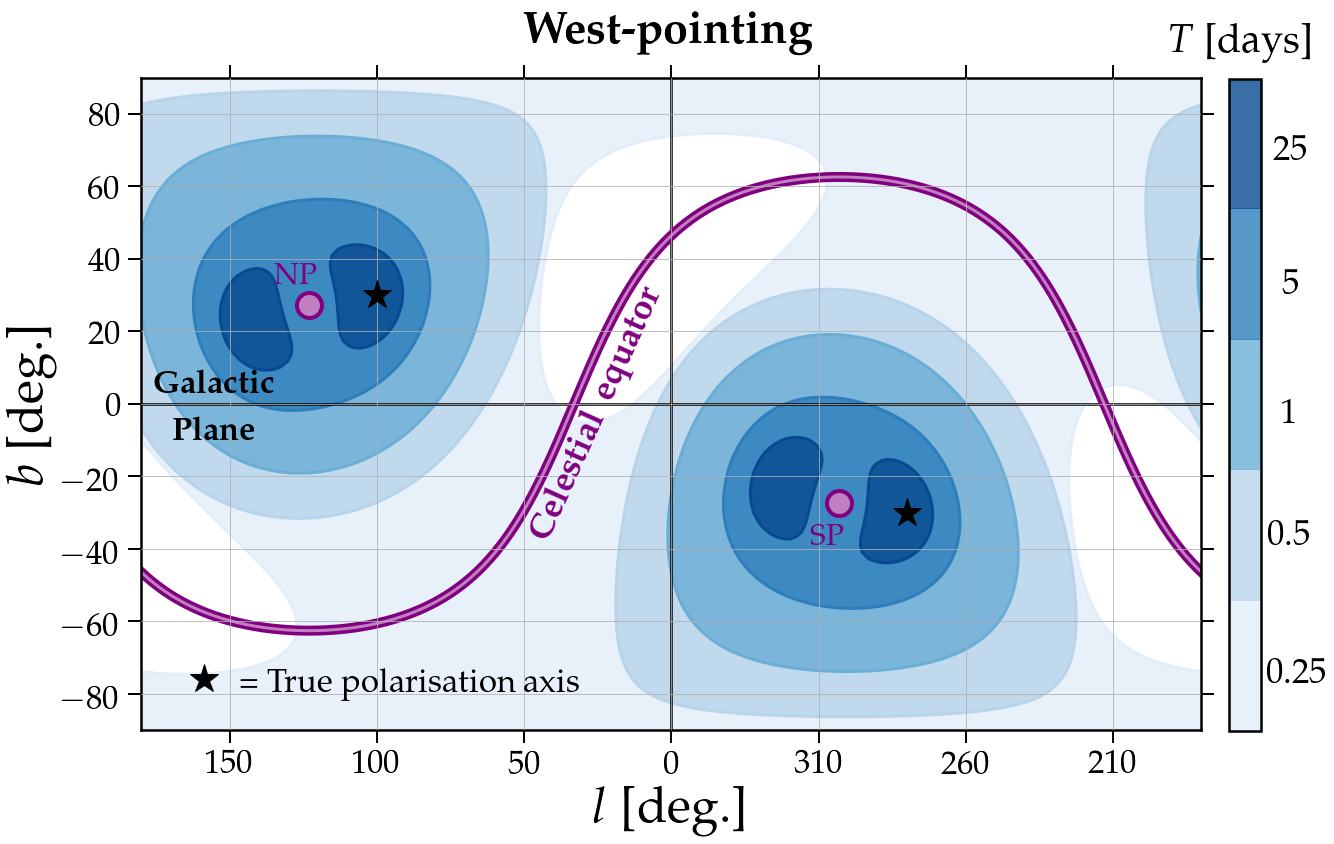

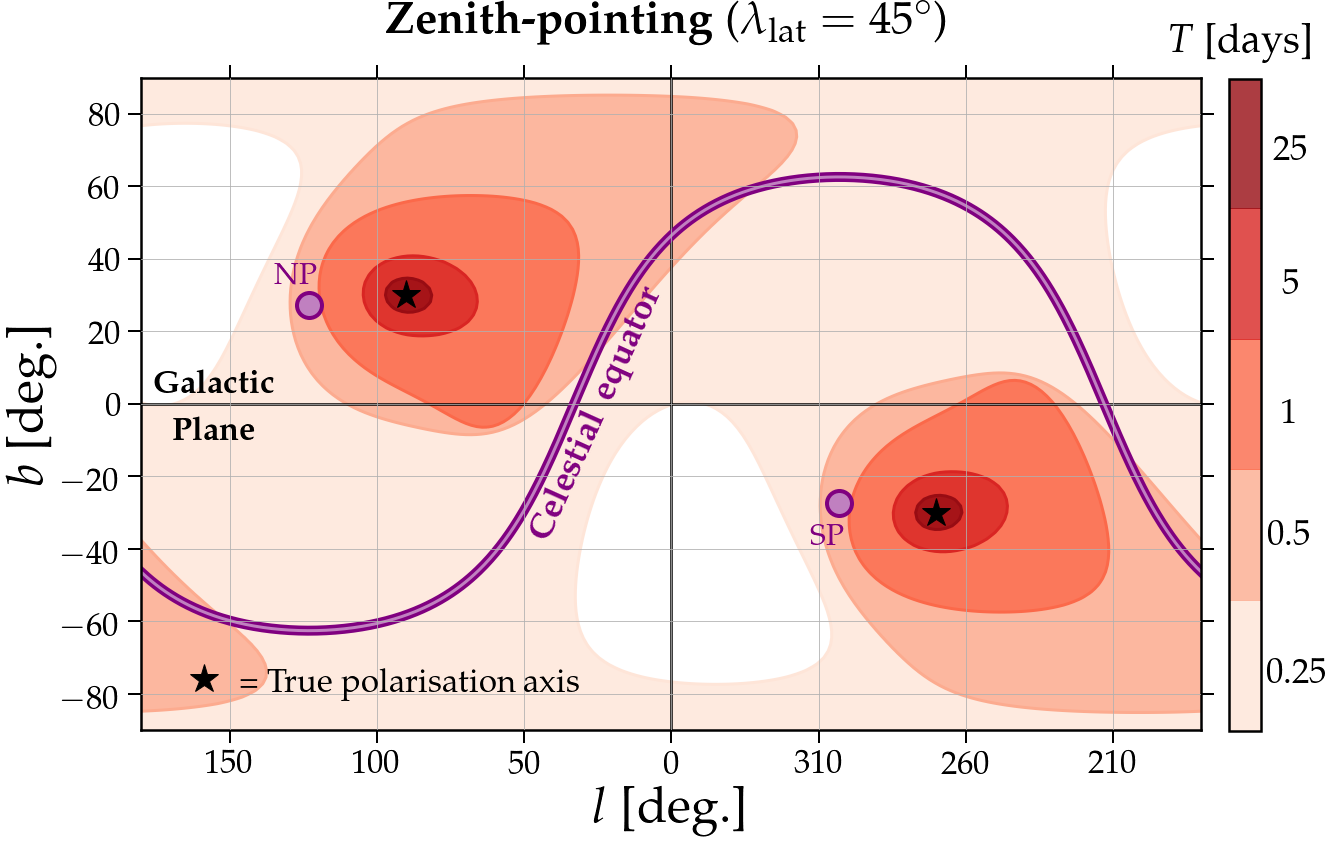

In [73]:
def GalacticMap_Rectangular(L_map,l_test,b_test,cmap,TS=-6.17,alph=0.8):

    # Set up figure
    fig,ax1 = MySquarePlot('$l$ [deg.]', '$b$ [deg.]',size_x=19,tfs=33,lfs=50)
    vmin = TS
    vmax = 0
    levels = [TS,0]
    cols = (cmap(linspace(0.1,0.9,len(L_map))))
    im = plt.contourf(rad2deg(l)-1000, rad2deg(b),L_map[0],cmap=cmap,levels=len(L_map)-1,alpha=alph)
    
    for i in range(0,len(L_map)):
        ax1.contourf(rad2deg(l), rad2deg(b),L_map[i],levels=levels,colors=cols[i,:].reshape(-1,4),alpha=alph)
        #ax1.contour(rad2deg(l), rad2deg(b),L_map[i],linestyles='-',colors='k',linewidths=4,levels=[TS])
        ax1.contour(rad2deg(l), rad2deg(b),L_map[i],linestyles='-',colors=cols[i,:].reshape(-1,4),linewidths=3,levels=[TS])


    ax1.plot([0,0],[-90,90],'-',color='k',lw=2.5)
    ax1.plot([-180,180],[0,0],'-',color='k',lw=2.5)

#     l_eclp,b_eclp = Ecliptic(100)
#     l_eclp = append(-180.5,l_eclp)
#     l_eclp = append(l_eclp,180.5)
#     b_eclp = append(b_eclp[-1],b_eclp)
#     b_eclp = append(b_eclp,b_eclp[0])
#     ax1.plot(l_eclp,b_eclp,'-',color='k',lw=7)
#     ax1.plot(l_eclp,b_eclp,'-',color='orange',lw=5)

    plt.plot(l_NP,b_NP,'o',mec='purple',mfc=col_alpha('purple',0.5),mew=4,ms=25)
    plt.plot(l_NP-180,-b_NP,'o',mec='purple',mfc=col_alpha('purple',0.5),mew=4,ms=25)

    l_eqt,b_eqt = Equator(500)
    plt.plot(l_eqt,b_eqt,'r-')
    ax1.plot(l_eqt,b_eqt,'-',color='purple',lw=10)
    ax1.plot(l_eqt,b_eqt,'-',color=col_alpha('purple',0.5),lw=3)

    ax1.plot(l_test,b_test,'*',ms=30,mec='k',mfc='k',zorder=1000)
    ax1.plot(l_test-180,-b_test,'*',ms=30,mec='k',mfc='k',label='= True polarisation axis',zorder=1000)

    ax1.set_xlim([180,-180])

    xtick = ax1.get_xticks([]).astype(int)
    xtick[xtick<0] = xtick[xtick<0]+360
    ax1.set_xticklabels(xtick)
    ax1.tick_params(tickdir='out')
    ax1.grid(zorder=200)
    ax1.set_axisbelow(False)

    plt.legend(frameon=False,loc='lower left',handletextpad=0.1)
    plt.text(155,3,r'{\bf Galactic}',ha='center')
    plt.text(155,-10,r'{\bf Plane}',ha='center')
    plt.text(135,33,'NP',fontsize=30,color='purple')
    plt.text(-47,-39,'SP',fontsize=30,color='purple')

    plt.text(25,-36.5,r'{\bf Celestial \,equator}',ha='center',color='purple',rotation=65.7,fontsize=35)

    cbar_ax1 = fig.add_axes([0.92, 0.124, 0.1, 0.755])
    cbar1 = plt.colorbar(im,extend='max',use_gridspec=True,ticks=[],aspect=20,fraction=1.0)
    cbar_ax1.axis('off')

    plt.gcf().text(0.51,0.925,tit,ha='center',fontsize=45,color='w')
    plt.gcf().text(0.51,0.92,tit,ha='center',fontsize=45)
    
    plt.gcf().text(0.93,0.91,'$T$ [days]',rotation=0,rotation_mode='anchor',ha='center',fontsize=40)
    plt.gcf().text(0.97,0.18,'0.25',fontsize=35,ha='center')
    plt.gcf().text(0.965,0.34,'0.5',fontsize=35,ha='center')
    plt.gcf().text(0.965,0.48,'1',fontsize=35,ha='center')
    plt.gcf().text(0.965,0.63,'5',fontsize=35,ha='center')
    plt.gcf().text(0.965,0.785,'25',fontsize=35,ha='center')

    return fig,ax1

tit = r'{\bf North-pointing} ($\lambda_{\rm lat} = 45^\circ$)'

fig,ax = GalacticMap_Rectangular([L_map_N31,L_map_N32,L_map_N33,L_map_N34,L_map_N35],l_test1,b_test1,cmap1)


MySaveFig(fig,'PolarisationMap_North')

tit = r'{\bf West-pointing}'

fig,ax = GalacticMap_Rectangular([L_map_W31,L_map_W32,L_map_W33,L_map_W34,L_map_W35],l_test2,b_test2,cmap2)



MySaveFig(fig,'PolarisationMap_West')

tit = r'{\bf Zenith-pointing} ($\lambda_{\rm lat} = 45^\circ$)'

fig,ax = GalacticMap_Rectangular([L_map_Z31,L_map_Z32,L_map_Z33,L_map_Z34,L_map_Z35],l_test3,b_test3,cmap3)

MySaveFig(fig,'PolarisationMap_Zenith')

In [ ]:
# lw=2.5
lfs=45
tfs=25
size_x=13
size_y=12
plt.rcParams['axes.linewidth'] = lw
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=tfs)


# Set up figure
fig, axarr = plt.subplots(1, 3,figsize=(20,10))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.1)
ax1 = plt.subplot(gs[0],projection=ccrs.Mollweide())
ax2 = plt.subplot(gs[1],projection=ccrs.Mollweide())
ax3 = plt.subplot(gs[2],projection=ccrs.Mollweide())


vmin = -6
vmax = 0

cmap = cmap1
levels = [-6,0]

#im = ax1.pcolormesh(-rad2deg(l), rad2deg(b),L_map_N1,\
#           transform=ccrs.PlateCarree(),cmap=cmap,rasterized=True,vmin=vmin,vmax=vmax)
ax1.contourf(-rad2deg(l), rad2deg(b),L_map_Z11,levels=levels,cmap=cmap3,transform=ccrs.PlateCarree(),alpha=0.5)
ax1.contourf(-rad2deg(l), rad2deg(b),L_map_Z12,levels=levels,cmap=cmap3,transform=ccrs.PlateCarree(),alpha=0.5)
ax1.contourf(-rad2deg(l), rad2deg(b),L_map_Z13,levels=levels,cmap=cmap3,transform=ccrs.PlateCarree(),alpha=0.5)

#im = ax2.pcolormesh(-rad2deg(l), rad2deg(b),L_map_W1,\
#           transform=ccrs.PlateCarree(),cmap=cmap2,rasterized=True,vmin=vmin,vmax=vmax)
ax2.contourf(-rad2deg(l), rad2deg(b),L_map_Z21,levels=levels,cmap=cmap3,transform=ccrs.PlateCarree(),alpha=0.5)
ax2.contourf(-rad2deg(l), rad2deg(b),L_map_Z22,levels=levels,cmap=cmap3,transform=ccrs.PlateCarree(),alpha=0.5)
ax2.contourf(-rad2deg(l), rad2deg(b),L_map_Z23,levels=levels,cmap=cmap3,transform=ccrs.PlateCarree(),alpha=0.5)

#im = ax3.pcolormesh(-rad2deg(l), rad2deg(b),L_map_Z1,\
#           transform=ccrs.PlateCarree(),cmap=cmap3,rasterized=True,vmin=vmin,vmax=vmax)
ax3.contourf(-rad2deg(l), rad2deg(b),L_map_Z31,levels=levels,cmap=cmap3,transform=ccrs.PlateCarree(),alpha=0.5)
ax3.contourf(-rad2deg(l), rad2deg(b),L_map_Z32,levels=levels,cmap=cmap3,transform=ccrs.PlateCarree(),alpha=0.5)
ax3.contourf(-rad2deg(l), rad2deg(b),L_map_Z33,levels=levels,cmap=cmap3,transform=ccrs.PlateCarree(),alpha=0.5)



ax1.plot([0,0],[-90,90],'-',color='k',transform=ccrs.PlateCarree())
ax1.plot([-180,180],[0,0],'-',color='k',transform=ccrs.PlateCarree())
ax2.plot([0,0],[-90,90],'-',color='k',transform=ccrs.PlateCarree())
ax2.plot([-180,180],[0,0],'-',color='k',transform=ccrs.PlateCarree())
ax3.plot([0,0],[-90,90],'-',color='k',transform=ccrs.PlateCarree())
ax3.plot([-180,180],[0,0],'-',color='k',transform=ccrs.PlateCarree())

l_eclp,b_eclp = Ecliptic(100)
ax1.plot(-l_eclp,b_eclp,'--',color='k',alpha=0.5,lw=3,transform=ccrs.PlateCarree())
ax2.plot(-l_eclp,b_eclp,'--',color='k',alpha=0.5,lw=3,transform=ccrs.PlateCarree())
ax3.plot(-l_eclp,b_eclp,'--',color='k',alpha=0.5,lw=3,transform=ccrs.PlateCarree())

ax1.set_title(r'$\lambda_{\rm lat}$ = '+str(int(lat1))+'$^\circ$',pad=10)
ax2.set_title(r'$\lambda_{\rm lat}$ = '+str(int(lat2))+'$^\circ$',pad=10)
ax3.set_title(r'$\lambda_{\rm lat}$ = '+str(int(lat3))+'$^\circ$',pad=10)

ax1.plot(-l_test,b_test,'k*',transform=ccrs.PlateCarree(),ms=20,mec='k')
ax2.plot(-l_test,b_test,'k*',transform=ccrs.PlateCarree(),ms=20,mec='k')
ax3.plot(-l_test,b_test,'k*',transform=ccrs.PlateCarree(),ms=20,mec='k')

#plt.colorbar(im)


In [854]:
import tqdm

def AngleMeasurement_Map(n,Axis,T,lat,lon=0,dt=0.1,TS_thresh=-6,JD_0=0,Planar=False):
    l,b,chi_gal = chi_galactic(n)
    chi_test = zeros(shape=(1,3))

    dO_map = zeros(shape=(int(n/2),n))
    ii = 0
    for i in tqdm.notebook.tqdm(range(0,int(n/2))):
        for j in range(0,n):
            chi_test[0,:] = chi_gal[ii,:]
            
            _,_,L_map,dO = TestStatistic_Map(n,chi_test,Axis,T,lat,dt=dt,TS_thresh=TS_thresh,JD_0=JD_0,Planar=Planar)
            dO_map[i,j] = dO 
            ii += 1
    return l,b,dO_map

n = 100
T3 = 10
T2 = 2
T1 = 1

dt = 0.1

#l,b,dO_mapN3 = AngleMeasurement_Map(n,Axis1,T3,lat1,dt=dt)
#l,b,dO_mapN2 = AngleMeasurement_Map(n,Axis1,T2,lat1,dt=dt)
l,b,dO_mapN1 = AngleMeasurement_Map(n,Axis1,T1,lat1,dt=dt)

#l,b,dO_mapW3 = AngleMeasurement_Map(n,Axis2,T3,lat2,dt=dt)
#l,b,dO_mapW2 = AngleMeasurement_Map(n,Axis2,T2,lat2,dt=dt)
l,b,dO_mapW1 = AngleMeasurement_Map(n,Axis2,T1,lat2,dt=dt)

#l,b,dO_mapZ3 = AngleMeasurement_Map(n,Axis3,T3,lat3,dt=dt)
#l,b,dO_mapZ2 = AngleMeasurement_Map(n,Axis3,T2,lat3,dt=dt)
l,b,dO_mapZ1 = AngleMeasurement_Map(n,Axis3,T1,lat3,dt=dt)


KeyboardInterrupt: 

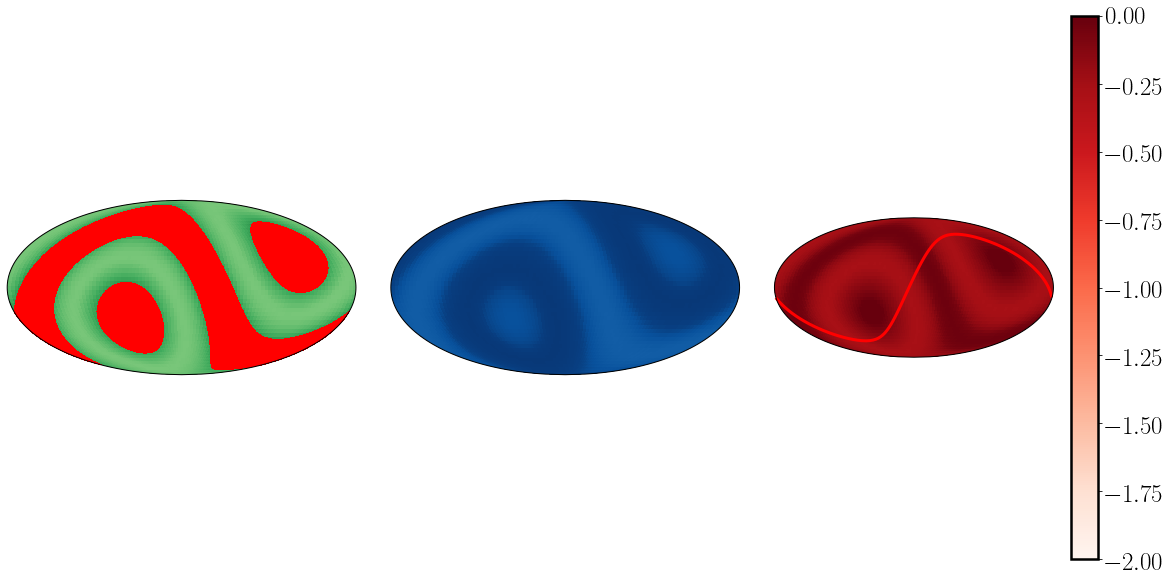

In [216]:
# Set up figure
fig, axarr = plt.subplots(1, 3,figsize=(20,10))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.1)
ax1 = plt.subplot(gs[0],projection=ccrs.Mollweide())
ax2 = plt.subplot(gs[1],projection=ccrs.Mollweide())
ax3 = plt.subplot(gs[2],projection=ccrs.Mollweide())

im = ax1.pcolormesh(-rad2deg(l), rad2deg(b),dO_mapN1,\
           transform=ccrs.PlateCarree(),cmap=cmap1,rasterized=True,vmin=0.1,vmax=1)

im = ax2.pcolormesh(-rad2deg(l), rad2deg(b),log10(dO_mapW1),\
           transform=ccrs.PlateCarree(),cmap=cmap2,rasterized=True,vmin=-2,vmax=0)
im = ax3.pcolormesh(-rad2deg(l), rad2deg(b),log10(dO_mapZ1),\
           transform=ccrs.PlateCarree(),cmap=cmap3,rasterized=True,vmin=-2,vmax=0)
# ax.contourf(rad2deg(l), rad2deg(b),L_map,\
#            transform=ccrs.PlateCarree(),cmap=cm.Greens,vmin=vmin,vmax=vmax)

ax.plot([0,0],[-90,90],'-',color='k',transform=ccrs.PlateCarree())
ax.plot([-180,180],[0,0],'-',color='k',transform=ccrs.PlateCarree())



l_eclp,b_eclp = Ecliptic(100)
plt.plot(-l_eclp,b_eclp,'r-',lw=3,transform=ccrs.PlateCarree())



plt.colorbar(im)


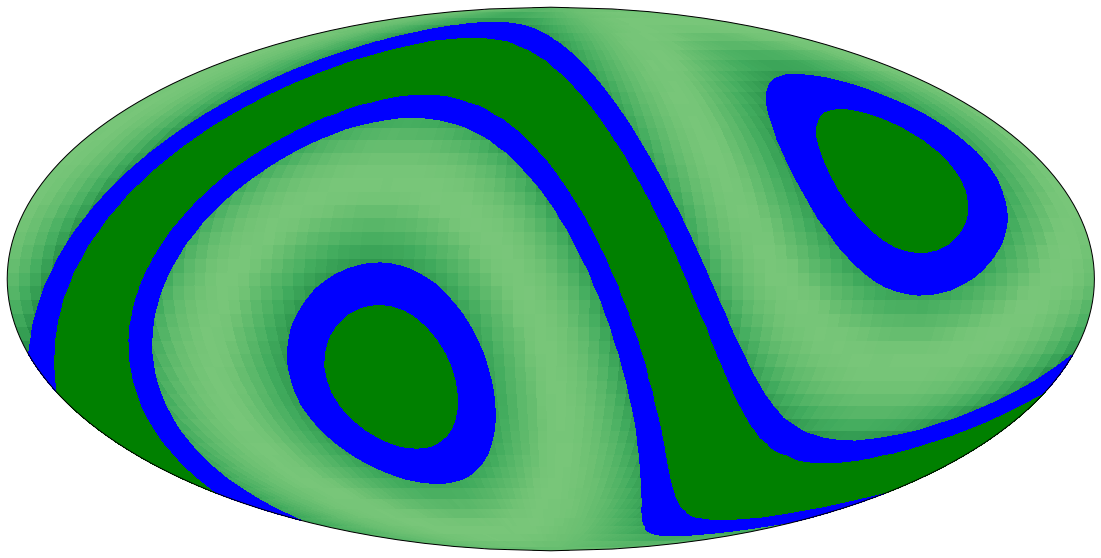

In [221]:
# Set up figure
fig, axarr = plt.subplots(1, 1,figsize=(20,10))
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.1)
ax1 = plt.subplot(gs[0],projection=ccrs.Mollweide())

im = ax1.pcolormesh(-rad2deg(l), rad2deg(b),dO_mapN1,\
           transform=ccrs.PlateCarree(),cmap=cmap1,rasterized=True,vmin=0.1,vmax=1)

ax1.contourf(-rad2deg(l), rad2deg(b),dO_mapN1,levels=[0.7,amax(dO_mapN1)],colors='green',transform=ccrs.PlateCarree())
ax1.contourf(-rad2deg(l), rad2deg(b),dO_mapN1,levels=[0.7,amax(dO_mapW1)],colors='blue',transform=ccrs.PlateCarree())


In [201]:
dO_mapN1

array([[0.58152307, 0.58152307, 0.58152307, ..., 0.58152307, 0.58152307,
        0.58152307],
       [0.59758135, 0.59839179, 0.59900111, ..., 0.59351442, 0.59552458,
        0.59758135],
       [0.61722069, 0.62296854, 0.62579933, ..., 0.60838611, 0.61292787,
        0.61722069],
       ...,
       [0.55756116, 0.55687964, 0.55458171, ..., 0.56093576, 0.55951289,
        0.55756116],
       [0.56572836, 0.56513739, 0.56462556, ..., 0.5691    , 0.5682677 ,
        0.56572836],
       [0.58152307, 0.58152307, 0.58152307, ..., 0.58152307, 0.58152307,
        0.58152307]])

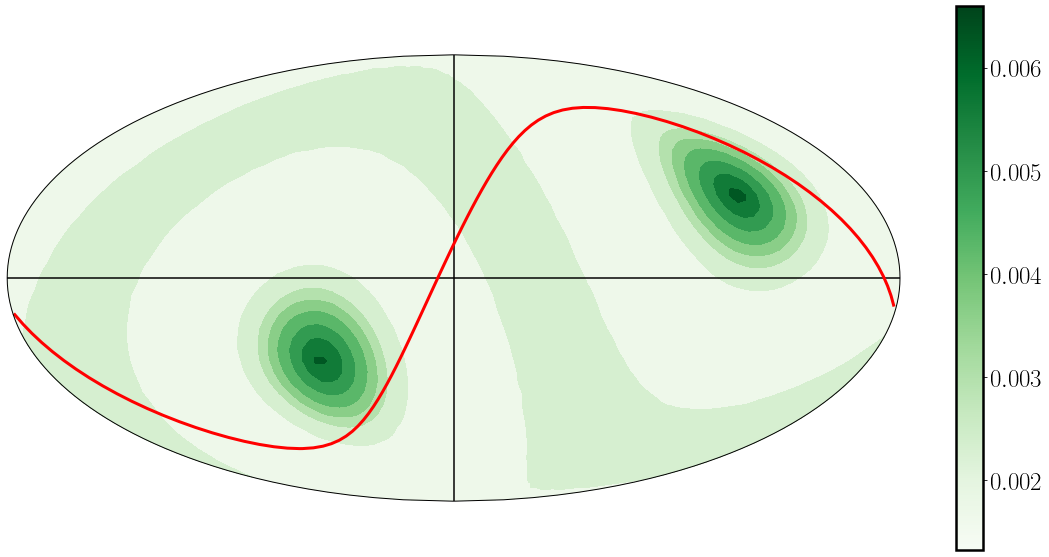

In [173]:
lw=2.5
lfs=45
tfs=25
size_x=13
size_y=12
plt.rcParams['axes.linewidth'] = lw
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=tfs)

# Set up figure
fig, axarr = plt.subplots(1, 1,figsize=(20,10))
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.1)

ax = plt.subplot(gs[0],projection=ccrs.Mollweide())
im = ax.pcolormesh(-rad2deg(l), rad2deg(b),dO_mapN3,\
           transform=ccrs.PlateCarree(),cmap=cm.Greens,rasterized=True)
ax.contourf(-rad2deg(l), rad2deg(b),dO_map2,\
           transform=ccrs.PlateCarree(),cmap=cm.Greens)

ax.plot([0,0],[-90,90],'-',color='k',transform=ccrs.PlateCarree())
ax.plot([-180,180],[0,0],'-',color='k',transform=ccrs.PlateCarree())



l_eclp,b_eclp = Ecliptic(100)
plt.plot(-l_eclp,b_eclp,'r-',lw=3,transform=ccrs.PlateCarree())


plt.colorbar(im)
